Presented by: Reza Saadatyar 2022-2023<br/>
E-mail: Reza.Saadatyar92@gmail.com<br/>
[Link](https://github.com/RezaSaadatyar/Deep-Learning-in-python)

**Types of Recurrent Neural Networks**<br/>
![Alt text](1-2.jpg)  ![Alt text](2-2.jpg)

================================== Importing the required Libraries ===========================

In [162]:
import os
import sys
import math 
import numpy as np
import pandas as pd
import yfinance as yf          # pip install yfinance
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

========================================= Functions ==================================

In [163]:
# =============================================== Preparing data =====================================================
def Prepare_data(data):  
     # -------------------------------------------- Step 1.1: Check type data ----------------------------------------     
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    return data

# ============================================= Sequences data =======================================================
def sequences_data(data, x_steps=6, y_steps=2, train_size=0.7, nfeatures=1):
    # !============================================= Step 1: Split data ==============================================
    # -------------------------------------------- Step 1.1: Check type data -----------------------------------------    
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # --------------------------------------------- Step 1.3: Data Splitting -----------------------------------------   
    n = math.floor(data.shape[0] * train_size)
    dat_train = data.iloc[0:n,:]
    data_train = dat_train.values.reshape(-1,1)
    
    dat_test = data.iloc[data_train.shape[0]-x_steps:,:]
    data_test = dat_test.values.reshape(-1,1)
    # !============================================== Step 2: Scaling ================================================
    mod = MinMaxScaler(feature_range=(0, 1))
    data_train = mod.fit_transform(data_train)
    data_test = mod.transform(data_test)
    # !============================================== Step 3: Sequences ==============================================
    # --------------------------------------------- Step 3.1: Sequences x_train --------------------------------------
    x_train = []
    y_train = []
    for i in range(x_steps, len(data_train)-y_steps+1):
        x_train.append(data_train[i-x_steps:i, 0])
        y_train.append(data_train[i:i+y_steps, 0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], nfeatures))
    # -------------------------------------------- Step 3.2: Sequences x_test ----------------------------------------
    x_test = []
    y_test = []
    for i in range(x_steps, len(data.iloc[n:,:])+x_steps-y_steps+1):
        x_test.append(data_test[i-x_steps:i, 0])
        y_test.append(data_test[i:i+y_steps, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, dat_train, dat_test, mod

# ============================================= Plot prediction ======================================================
def plot_prediction(data_train, data_test, pred_train, pred_test, mod):
    
    _, axs = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(8, 3))
    # axs[0].plot(data.iloc[0:pred_train.shape[0],:], label='Train data')
    axs[0].plot(data_train, label='Train data')
    axs[0].plot(data_train.index[:pred_train.shape[0]], mod.inverse_transform(pred_train[:,0].reshape(-1,1)), label='Estimate')
    axs[0].legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)

    axs[1].plot(data_test, label='Test data')
    axs[1].plot(data_test.index[:pred_test.shape[0]:], mod.inverse_transform(pred_test[:,0].reshape(-1,1)), label='Estimate')
    axs[1].legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)

    axs[0].autoscale(enable=True, axis="x",tight=True)
    axs[1].autoscale(enable=True, axis="x",tight=True)
    plt.subplots_adjust(wspace=0.04, hspace=0.2)
    
# ====================================== Plot loss for train & test ==================================================   
def plot_loss(train_model):
    _, axs = plt.subplots(nrows=1, sharey='row', figsize=(4, 3))
    axs.plot(train_model.history["loss"], label='Loss_train')
    axs.plot(train_model.history["val_loss"], label='Loss_test',)
    axs.legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)
    axs.autoscale(enable=True, axis="x",tight=True)

*Step 1.1: Load Data*

In [164]:
data = sm.datasets.sunspots.load_pandas()  
data = data.data["SUNACTIVITY"]

In [165]:
data = Prepare_data(data)
print(f"{data = }")

data =      SUNACTIVITY
0            5.0
1           11.0
2           16.0
3           23.0
4           36.0
..           ...
304         40.4
305         29.8
306         15.2
307          7.5
308          2.9

[309 rows x 1 columns]


*Step 1.2: Plot data*

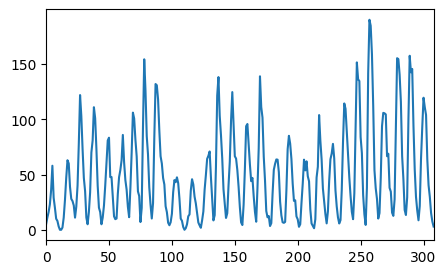

In [166]:
_, axs = plt.subplots(nrows=1,sharey='row', figsize=(5,3))
axs.plot(data)
axs.set_xlabel('', fontsize=10)
axs.set_title(f"", fontsize=10)
axs.set_ylabel('', fontsize=10)
axs.autoscale(enable=True, axis="x",tight=True)

*Step 2: Creating sequences*

In [167]:
x_steps = 6
y_steps = 2
x_train, y_train, x_test, y_test, data_train, data_test, mod = sequences_data(data, x_steps, y_steps, train_size=0.6, nfeatures=1)

*Step 3.1: Creating the Simple [RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) Model using:*<br/>
[Sequential model](https://keras.io/guides/sequential_model/)<br/>
[Dense layer](https://keras.io/api/layers/core_layers/dense/)<br/>
[Activation functions](https://keras.io/api/layers/activations/)<br/>

*inputs $\Rightarrow$ Preparing 3-Dimensional Input for Sequential Model, with shape [batch, timesteps, feature].*<br/>
![Alt text](<Simple RNN.png>)    ![Alt text](<Simple RNN 1.png>)

In [168]:
model = Sequential([SimpleRNN(50, return_sequences=True),
                            SimpleRNN(50),
                            Dense(y_steps)])
model.layers                                 # Print the model parameters

*Step 3.2: [Model compile](https://keras.io/api/models/model_training_apis/)*<br/>
[Metrics](https://keras.io/api/metrics/regression_metrics/)<br/>

In [149]:
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])  # Regression:mean_squared_error

*Step 3.3: Training the Model*<br/>
[Fit method](https://keras.io/api/models/model_training_apis/)

In [151]:
train_model = model.fit(x_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0851

5/5 [==============================] - 0s 61ms/step - loss: 0.0135 - mean_absolute_error: 0.0874 - val_loss: 0.0213 - val_mean_absolute_error: 0.1104
Epoch 2/100
5/5 [==============================] - 0s 65ms/step - loss: 0.0146 - mean_absolute_error: 0.0855 - val_loss: 0.0219 - val_mean_absolute_error: 0.1109
Epoch 3/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0138 - mean_absolute_error: 0.0895 - val_loss: 0.0202 - val_mean_absolute_error: 0.1055
Epoch 4/100
5/5 [==============================] - 0s 51ms/step - loss: 0.0129 - mean_absolute_error: 0.0815 - val_loss: 0.0195 - val_mean_absolute_error: 0.1057
Epoch 5/100
5/5 [==============================] - 0s 31ms/step - loss: 0.0130 - mean_absolute_error: 0.0847 - val_loss: 0.0197 - val_mean_absolute_error: 0.1054
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0129 - mean_absolute_error: 0.0809 - val_loss: 0.0198 - val_mean_absolute_error: 0.1067
Epoch 7/100
5/5 [=======================

*Step 3.4: Predicting for train & test data*

In [161]:
pred_train = simple_rnn_mod.predict(x_train)
pred_test = simple_rnn_mod.predict(x_test)

4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


*Calculating the correctness for train & test data*

*Plot of Training and Test Loss Functions*

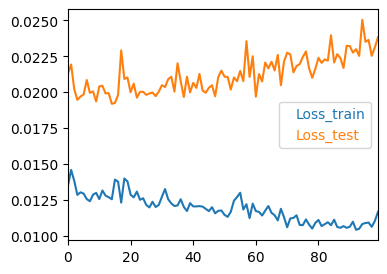

In [160]:
plot_loss(train_model)

*Plot of actuals and predictions for train & test data*

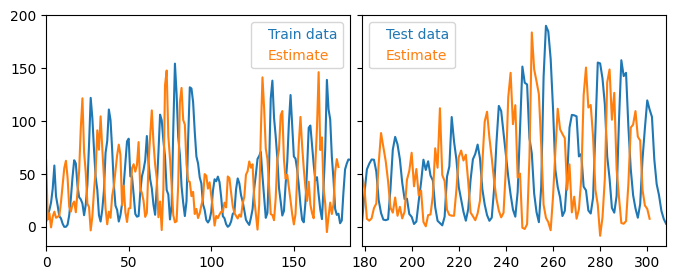

In [144]:
plot_prediction(data_train, data_test, pred_train, pred_test, mod)